# Бета-Банк

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Работа включает:
1. Загрузку и подготовку данных;
2. Исследование баланса классов, обучение модели без учёта дисбаланса;
3. Улучшение качества модели, учитывая дисбаланс классов. Обучение разных моделей и поиск лучшей;
4. Финальное тестирование.

## Загрузка и подготовка данных

In [203]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler
)
from sklearn.metrics import (
    f1_score, 
    roc_curve, 
    roc_auc_score,
    recall_score
)
from sklearn.utils import shuffle, resample
import numpy as np
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

In [80]:
try:
    df = pd.read_csv('/datasets/Churn.csv')
except:
    df = pd.read_csv('Churn.csv')

In [81]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [83]:
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median())

Подготовим данные.


1. Признаки _CustomerId_ (уникальный идентификатор клиента), _Surname_ (фамилия) и _RowNumber_ ( индекс строки в данных) — не несут в себе полезности для поиска зависимостей, удалим эти признаки


2. Преобруем следующие категориальные признаки в численные:

    - Geography — страна проживания,
    - Gender — пол.


3. Масштабируем признаки:

    - CreditScore — кредитный рейтинг,
    - Balance — баланс на счёте,
    - EstimatedSalary — предполагаемая зарплата.
 

In [84]:
df = df.drop(['CustomerId','Surname','RowNumber'], axis=1)

In [85]:
target = df['Exited']
features = df.drop('Exited', axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345)

In [86]:
ohe_features = features_train.select_dtypes(include='object').columns.to_list()

encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(features_train[ohe_features])
features_train[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train[ohe_features])
features_valid[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_valid[ohe_features])
features_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test[ohe_features])

features_train = features_train.drop(ohe_features, axis=1)
features_valid = features_valid.drop(ohe_features, axis=1)
features_test = features_test.drop(ohe_features, axis=1)

In [87]:
numeric = ['CreditScore', 'Balance', 'EstimatedSalary', 'Age', 'Tenure', 'NumOfProducts']

scaler = StandardScaler()
scaler.fit(features_train[numeric]) 

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_valid

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
8532,-0.699824,-0.373192,-1.101690,-1.233163,0.830152,1,0,-0.015173,0.0,0.0,0.0
5799,-0.284431,0.575842,-0.737696,-1.233163,-0.891560,1,1,1.471724,0.0,0.0,0.0
5511,0.151731,-0.657902,-1.829679,0.438711,-0.891560,1,0,-1.367107,1.0,0.0,1.0
7365,-0.876366,-0.278288,1.810266,1.239884,-0.891560,1,1,-0.786517,0.0,1.0,0.0
7367,-0.481743,0.291132,1.810266,-1.233163,0.830152,1,0,1.358533,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
6480,0.276349,-1.417129,0.354288,0.617449,0.830152,0,1,0.628182,0.0,0.0,0.0
8194,-0.211738,0.291132,-0.373701,0.797229,-0.891560,1,0,0.026002,0.0,0.0,1.0
1279,-1.364452,0.006422,0.354288,-1.233163,0.830152,0,1,-1.249087,0.0,0.0,0.0
6532,1.075979,2.663716,-0.373701,-1.233163,2.551864,1,1,-0.111107,0.0,0.0,1.0


## Исследование баланса классов, обучение модели без учёта дисбаланса

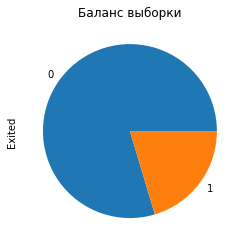

In [88]:
df.groupby(by='Exited')['Exited'].count().plot(kind='pie').set_title('Баланс выборки');

Классы несбалансированны, отношение объектов класса 0 к 1 более чем 75:25. Обучим модель без учета дисбаланса.

### Логистическая регрессия

In [89]:
model_log_disb = LogisticRegression(random_state=12345, solver='liblinear')
model_log_disb.fit(features_train, target_train)
predictions_valid = model_log_disb.predict(features_valid)
print(f1_score(target_valid, predictions_valid))

0.33108108108108103


In [90]:
def roc_auc_plot_and_print(target_valid, probabilities_one_valid):
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim(0, 1) 
    plt.ylim(0, 1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-кривая")
    plt.show()
    print('AUC_ROC =', roc_auc_score(target_valid, probabilities_one_valid))

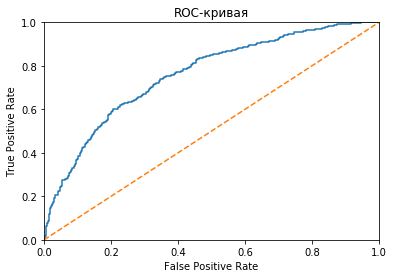

AUC_ROC = 0.7587512627102753


In [91]:
probabilities_valid = model_log_disb.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_plot_and_print(target_valid, probabilities_one_valid) 

### Случайный лес

In [149]:
best_model_frst_disb = None
best_f1 = 0
best_est_frst = 0
best_depth_frst = 0
for est in range(10, 100, 10):
    for depth in range (1, 12):
        model_frst_disb = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_frst_disb.fit(features_train, target_train)
        predictions_valid = model_frst_disb.predict(features_valid)
        f1 = f1_score(target_valid, predictions_valid)
        if f1 > best_f1:
            best_model_frst_disb = model_frst_disb 
            best_f1 = f1
            best_est_frst = est
            best_depth_frst = depth

print("Точность наилучшей модели на валидационной выборке:", round(best_f1, 3), \
      "Количество деревьев:", best_est_frst, "Максимальная глубина:", best_depth_frst)

Точность наилучшей модели на валидационной выборке: 0.589 Количество деревьев: 10 Максимальная глубина: 10


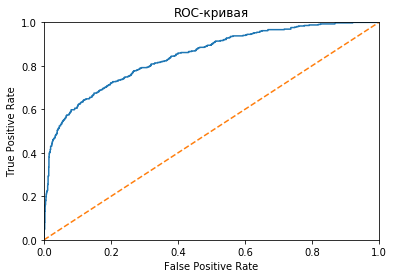

AUC_ROC = 0.8456038023457679


In [151]:
probabilities_valid = best_model_frst_disb.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_plot_and_print(target_valid, probabilities_one_valid) 

### Дерево решений

In [132]:
best_model_tree_disb = None
best_result_tree_disb = 0
best_f1 = 0
for depth in range(1, 8):
    model_tree_disb = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree_disb.fit(features_train, target_train)
    predictions_valid = model_tree_disb.predict(features_valid)
    f1 = f1_score(target_valid, predictions_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_model_tree_disb = model_tree_disb
        best_depth_tree_disb = depth

print("F1 наилучшей модели на валидационной выборке:", round(best_f1, 3), "Глубина дерева:", best_depth_tree_disb)

F1 наилучшей модели на валидационной выборке: 0.57 Глубина дерева: 6


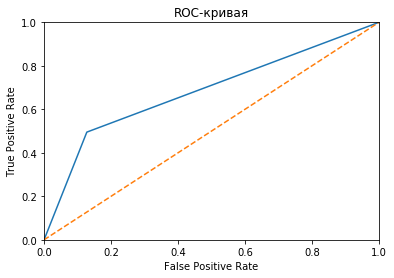

AUC_ROC = 0.6837644190927842


In [95]:
probabilities_valid = best_model_tree_disb.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_plot_and_print(target_valid, probabilities_one_valid) 

### Вывод

Модели по сравнению со случайной показывает себя лучше, но качество - плохое, что видно по метрикам F1 и AUC-ROC. Лучшие показатели имеет модель случайного леса F1 = 0.58 и AUC-ROC = 0.84 при количестве деревьев равном 10 и глубине деревьев равной 10.

## Улучшение качества модели, учитывая дисбаланс классов. Обучение разных моделей и поиск лучшей

### Взвешивание классов

Если указать class_weight='balanced', алгоритм посчитает, во сколько раз класс «0» встречается чаще класса «1»

#### Логистическая регрессия

In [96]:
model_log_balance = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_log_balance.fit(features_train, target_train)
predictions_valid = model_log_balance.predict(features_valid)
print(f1_score(target_valid, predictions_valid))

0.4888507718696398


In [161]:
probabilities_valid = model_log_balance.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

b_threshold = 0
b_f1 = 0
for threshold in np.arange(0, 0.8, 0.01):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > b_f1:
        b_f1 = f1
        b_threshold = threshold
print(b_f1, b_threshold)

0.5 0.55


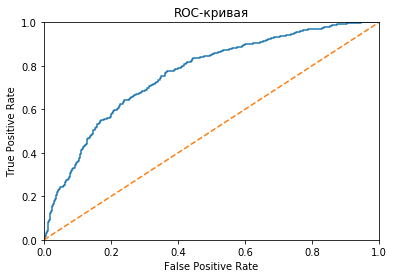

AUC_ROC = 0.7637310291013133


In [162]:
roc_auc_plot_and_print(target_valid, probabilities_one_valid) 

#### Случайный лес

In [157]:
best_model_frst_balance = None
best_f1 = 0
best_est_frst = 0
best_depth_frst = 0
for est in range(10, 150, 10):
    for depth in range (1, 12):
        model_frst_balance = RandomForestClassifier(random_state=12345, n_estimators=est, 
                                                    max_depth=depth, class_weight='balanced')
        model_frst_balance.fit(features_train, target_train)
        predictions_valid = model_frst_balance.predict(features_valid)
        f1 = f1_score(target_valid, predictions_valid)
        if f1 > best_f1:
            best_model_frst_balance = model_frst_balance 
            best_f1 = f1
            best_est_frst = est
            best_depth_frst = depth

print("Точность наилучшей модели на валидационной выборке:", round(best_f1, 3), \
      "Количество деревьев:", best_est_frst, "Максимальная глубина:", best_depth_frst)

Точность наилучшей модели на валидационной выборке: 0.629 Количество деревьев: 110 Максимальная глубина: 9


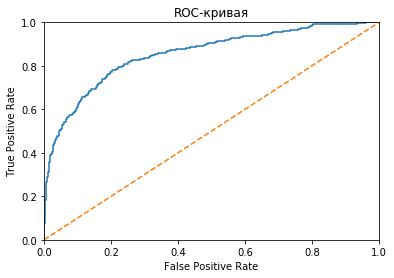

AUC_ROC = 0.8544813360835717


In [158]:
probabilities_valid = best_model_frst_balance.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_plot_and_print(target_valid, probabilities_one_valid) 

#### Дерево решений

In [131]:
best_model_tree_balance = None
best_depth_tree_balance = 0
best_f1 = 0
for depth in range(1, 8):
    model_tree_balance = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model_tree_balance.fit(features_train, target_train)
    predictions_valid = model_tree_balance.predict(features_valid)
    f1 = f1_score(target_valid, predictions_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_model_tree_balance = model_tree_balance
        best_depth_tree_balance = depth

print("F1 наилучшей модели на валидационной выборке:", round(best_f1, 3), "Глубина дерева:", best_depth_tree_balance)

F1 наилучшей модели на валидационной выборке: 0.596 Глубина дерева: 5


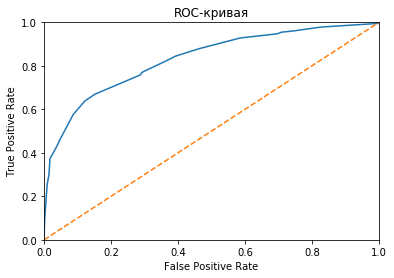

AUC_ROC = 0.8310244134068074


In [133]:
probabilities_valid = best_model_tree_balance.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_plot_and_print(target_valid, probabilities_one_valid) 

#### Вывод

Взвешивание классов положительно повлияло на качество всех моделей, лучший результат у модели случайного леса: F1 = 0.629 и AUC-ROC = 0.85 при количестве деревьев равное 110 и их максимальной глубине равной 9.

### Upsampling

Увеличим количество объектом "меньшего" класса.

In [102]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

#### Логистическая регрессия

In [192]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

model_log_up = LogisticRegression(random_state=12345, solver='liblinear')
model_log_up.fit(features_upsampled, target_upsampled)
predictions_valid = model_log_up.predict(features_valid)
print("F1:", f1_score(target_valid, predictions_valid))

F1: 0.5


In [193]:
probabilities_valid = model_log_up.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

b_threshold = 0
b_f1 = 0
for threshold in np.arange(0, 0.8, 0.01):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > b_f1:
        b_f1 = f1
        b_threshold = threshold
print(b_f1, b_threshold)

0.5018867924528302 0.47000000000000003


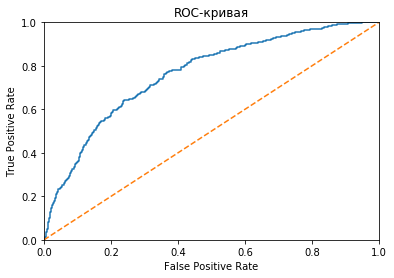

AUC_ROC = 0.7626815429563449


In [194]:
probabilities_valid = model_log_up.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_plot_and_print(target_valid, probabilities_one_valid) 

Модель логистической регрессии дала результаты, ниже требуемых 0.59. Лучший результат достигается при смещении порога на 0,05. AUC_ROC увеличилась, оценим другие модели.

#### Случайный лес

In [195]:
best_model_frst_up = None
best_f1 = 0
best_est_frst = 0
best_depth_frst = 0
for est in range(10, 100, 10):
    for depth in range (1, 12):
        model_frst_up = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_frst_up.fit(features_upsampled, target_upsampled)
        predictions_valid = model_frst_up.predict(features_valid)
        f1 = f1_score(target_valid, predictions_valid)
        if f1 > best_f1:
            best_model_frst_up = model_frst_up 
            best_f1 = f1
            best_est_frst = est
            best_depth_frst = depth

print("Точность наилучшей модели на валидационной выборке:", round(best_f1, 3), \
      "Количество деревьев:", best_est_frst, "Максимальная глубина:", best_depth_frst)

Точность наилучшей модели на валидационной выборке: 0.638 Количество деревьев: 70 Максимальная глубина: 8


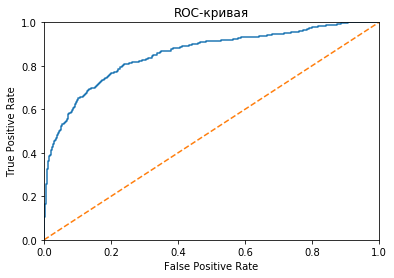

AUC_ROC = 0.8548548563685964


In [196]:
probabilities_valid = best_model_frst_up.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_plot_and_print(target_valid, probabilities_one_valid) 

#### Дерево решений

F1 наилучшей модели на валидационной выборке: 0.586 Глубина дерева: 5


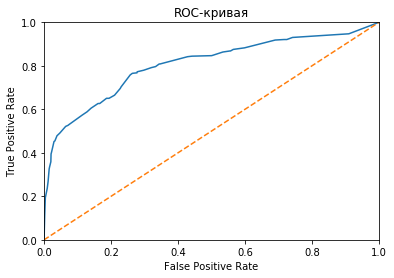

AUC_ROC = 0.8055554715428959


In [197]:
best_model_tree_up = None
best_result_tree_up = 0
best_f1 = 0
for depth in range(1, 8):
    model_tree_up = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree_up.fit(features_upsampled, target_upsampled)
    predictions_valid = model_tree_up.predict(features_valid)
    f1 = f1_score(target_valid, predictions_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_model_tree_up = model_tree_up
        best_depth_tree_up = depth

print("F1 наилучшей модели на валидационной выборке:", round(best_f1, 3), "Глубина дерева:", best_depth_tree_up)

probabilities_valid = model_tree_up.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_plot_and_print(target_valid, probabilities_one_valid)

#### Вывод

Увеличение доли меньшего класса положительно повлияло на все модели, результат близок к результатам взвешивания классов, но с выбором размера увеличения были достигнуты лучшие результаты. Лучшей по качеству моделью так же является модель случайного леса со значением F1 = 0.638, при количестве деревьев 70 и их максимальной глубине 8.

### Downsampling

#### Логистическая регрессия

In [164]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [178]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.4)

In [184]:
model_log_down = LogisticRegression(random_state=12345, solver='liblinear')
model_log_down.fit(features_downsampled, target_downsampled)
predictions_valid = model_log_down.predict(features_valid)
print("F1:", f1_score(target_valid, predictions_valid))

F1: 0.504875406283857


In [180]:
probabilities_valid = model_log_down.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

b_threshold = 0
b_f1 = 0
for threshold in np.arange(0, 0.8, 0.01):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > b_f1:
        b_f1 = f1
        b_threshold = threshold
print(b_f1, b_threshold)

0.504875406283857 0.5


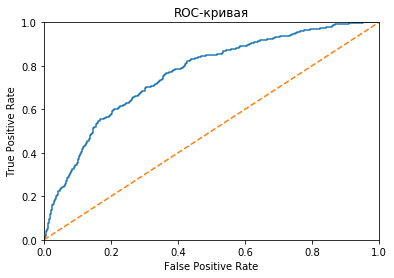

AUC_ROC = 0.7625666136378758


In [181]:
probabilities_valid = model_log_down.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_plot_and_print(target_valid, probabilities_one_valid) 

#### Случайный лес

In [183]:
best_model_frst_down = None
best_f1 = 0
best_est_frst = 0
best_depth_frst = 0
for est in range(10, 100, 10):
    for depth in range (1, 10):
        model_frst_down = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_frst_down.fit(features_downsampled, target_downsampled)
        predictions_valid = model_frst_down.predict(features_valid)
        f1 = f1_score(target_valid, predictions_valid)
        if f1 > best_f1:
            best_model_frst_down = model_frst_down 
            best_f1 = f1
            best_est_frst = est
            best_depth_frst = depth

print("Точность наилучшей модели на валидационной выборке:", round(best_f1, 3), \
      "Количество деревьев:", best_est_frst, "Максимальная глубина:", best_depth_frst)

Точность наилучшей модели на валидационной выборке: 0.635 Количество деревьев: 60 Максимальная глубина: 8


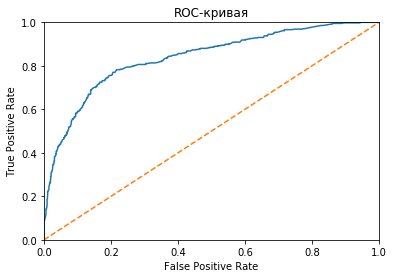

AUC_ROC = 0.8380547607957948


In [173]:
probabilities_valid = best_model_frst_down.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_plot_and_print(target_valid, probabilities_one_valid) 

#### Дерево решений

F1 наилучшей модели на валидационной выборке: 0.571 Глубина дерева: 7


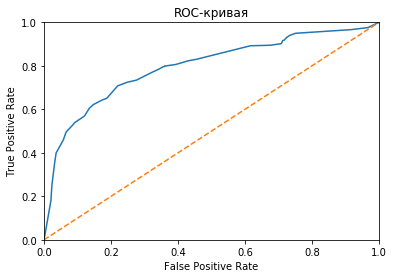

AUC_ROC = 0.796398175648292


In [182]:
best_model_tree_down = None
best_result_tree_down = 0
best_f1 = 0
for depth in range(1, 8):
    model_tree_down = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree_down.fit(features_downsampled, target_downsampled)
    predictions_valid = model_tree_down.predict(features_valid)
    f1 = f1_score(target_valid, predictions_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_model_tree_down = model_tree_down
        best_depth_tree_down = depth

print("F1 наилучшей модели на валидационной выборке:", round(best_f1, 3), "Глубина дерева:", best_depth_tree_down)

probabilities_valid = best_model_tree_down.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_plot_and_print(target_valid, probabilities_one_valid) 

#### Вывод

Уменьшение выборки превосходящего класса дало положительные результаты на всех моделях. У лучшей (случайный лес) F1 - 0.635, при количестве деревьев 60, максималььной глубине 8.

## Финальное тестирование

Проведем тестирование лучшей модели (случайный лес на расширенной тренировочной выборке) на заранее подготовленной тестовой выборке.

In [198]:
predictions_test = best_model_frst_up.predict(features_test)
print(f1_score(target_test, predictions_test))

0.6


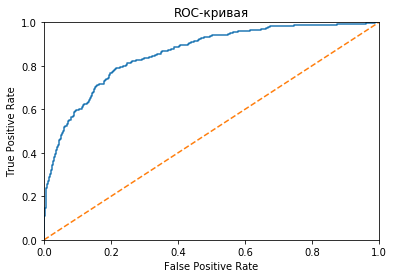

AUC_ROC = 0.8583793928982073


In [199]:
probabilities_test = best_model_frst_up.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
roc_auc_plot_and_print(target_test, probabilities_one_test) 

## Вывод 

В работе были выполнены следующие этапы:

1. Загрузка и подготовка данных - определены и преобразованы категориальные признаки, масштабированны численные;
2. Исследованы балансы классов, обучена модель без учёта дисбаланса и оценено ее качество - F1 = 0.33;
3. Улучшено качество модели, с учетом дисбаланса классов. Обучены разные модели и найдена лучшая 
    - произведен __upsampling__ обучающей выборки;
    - оценены модели логистической регресси, с учетом смещения порога, и дерева решений; 
    - найдена лучшая модель случайного леса, дающая F1 = 0.638 на валидационной выборке;
    - было оценено изменение AUC-ROC метрики.
4. Финальное тестирование найденной модели - F1 на тестовых данных составило 0.6.

In [202]:
dummy_model = DummyClassifier(strategy='constant', constant=1)
dummy_model.fit(features_train, target_train)
f1_score(dummy_model.predict(features_test), target_test)

0.3491539413949649

Дисбалансная модель логистической регрессии дает меньший результат.

In [204]:
recall_score(target_test, predictions_test, average='weighted')

0.83

Модель верно детектирует 83% клиентов по тестовой выборке.